In [1]:
#import potrebnih biblioteka
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser,download
from monai.transforms import LoadImage, LoadImaged, Orientation,Orientationd,EnsureChannelFirst,EnsureChannelFirstd,Compose
from rt_utils import RTStructBuilder
import json




C:\Users\adice\miniconda3\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
datadir=r'C:\Users\adice\OneDrive\Desktop\FAKULTET\AI\AI_Organ_Segmentation\data'

In [3]:
#preuzimanje slika sa TCIA-a
cart_name='nbia-32561725308558750'
cart_data=nbia.getSharedCart(cart_name)
df=nbia.downloadSeries(cart_data,format='df',path=datadir)


2024-09-04 19:04:22,555:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-32561725308558750'}
2024-09-04 19:04:23,843:INFO:Downloading 2 Series Instance UIDs (scans).
2024-09-04 19:04:24,796:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.147727698049157996140705051331 already downloaded.
2024-09-04 19:04:25,762:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668 already downloaded.
2024-09-04 19:04:25,762:INFO:Downloaded 0 out of 2 Series Instance UIDs (scans).
0 failed to download.
2 previously downloaded.


In [4]:
#inclijaliziranje foldera
CT_folder=os.path.join(datadir,'1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668')

In [5]:
#korištenje monai-a za postavljanje slike

image_loader=LoadImage(image_only=True)
CT=image_loader(CT_folder)

In [6]:
CT.meta

{'spacing': array([0.9765625, 0.9765625, 2.       ]),
 original_affine: array([[ -0.9765625 ,   0.        ,   0.        , 249.51171875],
        [  0.        ,  -0.9765625 ,   0.        , 401.01171875],
        [  0.        ,   0.        ,   2.        , -11.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ]]),
 space: RAS,
 affine: tensor([[ -0.9766,   0.0000,   0.0000, 249.5117],
         [  0.0000,  -0.9766,   0.0000, 401.0117],
         [  0.0000,   0.0000,   2.0000, -11.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64),
 spatial_shape: array([512, 512, 975]),
 original_channel_dim: nan,
 'filename_or_obj': 'C:\\Users\\adice\\OneDrive\\Desktop\\FAKULTET\\AI\\AI_Organ_Segmentation\\data\\1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668'}

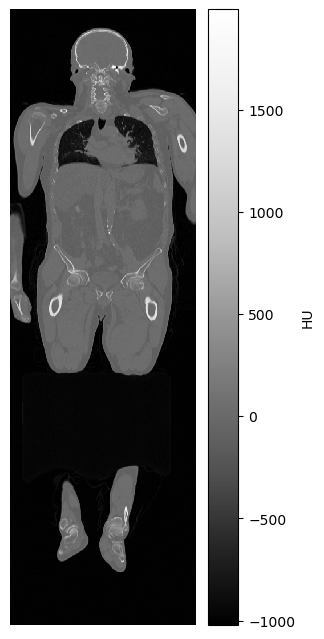

In [7]:
#pregled slike preko coronal slice

CT_coronal_slice=CT[:,256].cpu().numpy()

plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T,cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [8]:
#dodavanje channel dimenzije
channel_transofrm=EnsureChannelFirst()

CT=channel_transofrm(CT)

CT.shape

torch.Size([1, 512, 512, 975])

In [9]:
#reorganizacija slike
CT_organized=Orientation(axcodes=('LPS'))
CT=CT_organized(CT)
CT_coronal_slice=CT[0,:,256].cpu().numpy()


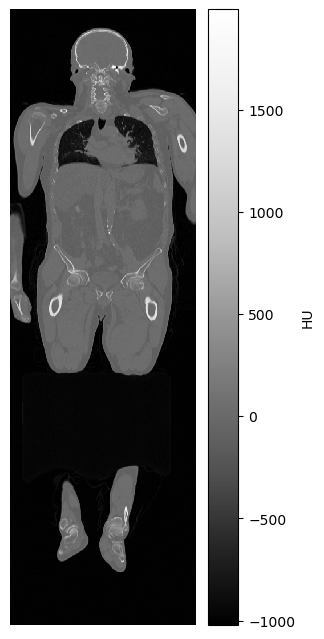

In [10]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T,cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [11]:
#korištenje pipline
preprocessing_pipline=Compose([LoadImage(image_only=True),
                               EnsureChannelFirst(),
                               Orientation(axcodes=('LPS'))])

In [12]:
CT=preprocessing_pipline(CT_folder)
CT_coronal_slice=CT[0,:,256].cpu().numpy()

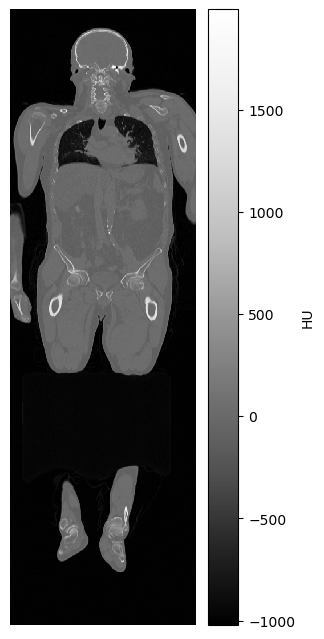

In [13]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T,cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [14]:
#instaliranje modela
model_name="wholeBody_ct_segmentation"
download(name=model_name,bundle_dir=datadir)

2024-09-04 19:04:57,946 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-09-04 19:04:57,947 - INFO - > name: 'wholeBody_ct_segmentation'
2024-09-04 19:04:57,947 - INFO - > bundle_dir: 'C:\\Users\\adice\\OneDrive\\Desktop\\FAKULTET\\AI\\AI_Organ_Segmentation\\data'
2024-09-04 19:04:57,948 - INFO - > source: 'monaihosting'
2024-09-04 19:04:57,948 - INFO - > remove_prefix: 'monai_'
2024-09-04 19:04:57,948 - INFO - > progress: True
2024-09-04 19:04:57,948 - INFO - ---


2024-09-04 19:04:59,016 - INFO - Expected md5 is None, skip md5 check for file C:\Users\adice\OneDrive\Desktop\FAKULTET\AI\AI_Organ_Segmentation\data\wholeBody_ct_segmentation_v0.2.4.zip.
2024-09-04 19:04:59,016 - INFO - File exists: C:\Users\adice\OneDrive\Desktop\FAKULTET\AI\AI_Organ_Segmentation\data\wholeBody_ct_segmentation_v0.2.4.zip, skipped downloading.
2024-09-04 19:04:59,017 - INFO - Writing into directory: C:\Users\adice\OneDrive\Desktop\FAKULTET\AI\AI_Organ_Segmentation\data.


In [52]:
#postavljanje model i config patha

model_path=os.path.join(datadir,'wholeBody_ct_segmentation','models','model_lowres.pt')

config_path=os.path.join(datadir,'wholeBody_ct_segmentation','configs','inference.json')

In [53]:
#kreiranje config instance
config=ConfigParser()
config.read_config(config_path)

In [54]:
#preporcesing pipline
preprocessing=config.get_parsed_content("preprocessing")


In [55]:
#korištenje preporcesing pipline
data=preprocessing({'image':CT_folder})

In [56]:
data

{'image': metatensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          ...,
 
          [[-1., -1., -1.,  ...

In [57]:
#otvaranje modela
model=config.get_parsed_content("network")

In [58]:
#mjenjanje random parametara sa train parametrima iz model.lowres.pt
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu'),weights_only=True))
model.eval();

In [59]:
#uzima podatke i model i vraća output modela uz ekstra korake
inferer=config.get_parsed_content("inferer")

In [60]:
#postprocesing radnje 
postprocessing=config.get_parsed_content("postprocessing")

In [90]:
#učitavanje podataka
datalist=[CT_folder]

config["datalist"]=datalist

dataloader= config.get_parsed_content("dataloader")

In [98]:
#kombinacija piplineova
data=preprocessing({'image':CT_folder}) #vraća dictionary

with torch.no_grad():
    data['pred']=inferer(data['image'].unsqueeze(0), network=model)

data['pred']=data['pred'][0]
data['image']=data['image'][0]

#postprocessing
data=postprocessing(data)

segmentation=torch.flip(torch.flip(data['pred'][0],dims=[2]),dims=[2])
segmentation=segmentation.cpu().numpy()

2024-09-05 14:48:37,350 INFO image_writer.py:197 - writing: eval\1.3.6.1.4.1.14519.5.2.1.3320.3273\1.3.6.1.4.1.14519.5.2.1.3320.3273_trans.nii.gz


In [99]:
segmentation.shape

(512, 512, 975)

In [129]:
# iniclizacija CT_slice=250 i segmentiranog dijela
slice_id=270
CT_coronal_slice=CT[0,:,slice_id].cpu().numpy()
segmentation_coronal_slice=segmentation[:,slice_id]

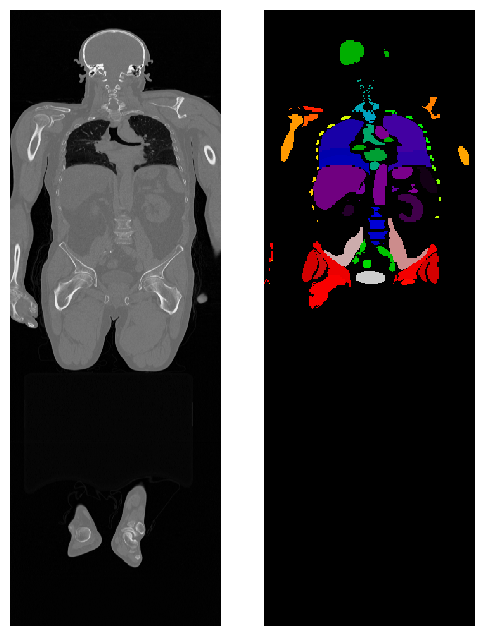

In [130]:
#prikaz CT sken i segmentiranog dijela
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T,cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T,cmap='nipy_spectral')
plt.axis('off')
plt.show()

In [89]:
#sa ovim podacima mozemo naprimjer prikazati zapreminu organa
#organ 5=jetra
number_liver_voxels=(segmentation==5).sum().item()
voxel_volume_cm3=np.prod(CT.meta['spacing']/10)
liver_volume_cm3=number_liver_voxels*voxel_volume_cm3
print(f"Volumen jetre iznosi {liver_volume_cm3:.1f} cm^3")

Volumen jetre iznosi 2737.4 cm^3
